Complexify MLP architecture by taking more characters in a sequence as an input and build a deeper model.

---
Wavenet is based on a paper published in 2016. It tries to predict audio sequences.

Tree-like structure.

In [53]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
words = open('names.txt', 'r').read().splitlines()

In [32]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)

In [33]:
block_size = 3
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            idx = stoi[ch]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [34]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# ------------------------------------------------------------------------------------------

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters:
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers:
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # forward pass:
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = xhat * self.gamma + self.beta
        # update the buffers (only when we're training):
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

# ------------------------------------------------------------------------------------------

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

# ------------------------------------------------------------------------------------------

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, idx):
        self.out = self.weight[idx]
        return self.out

    def parameters(self):
        return [self.weight]

# ------------------------------------------------------------------------------------------

class FlattenConsecutive:
    def __init__(self, n):
        self.n = n
        
    def __call__(self, x):
        B, T, C = x.shape # in our example, this was 4 x 8 x 10
        x = x.view(B, T//self.n, C*self.n) # C*n is the number of consecutive elements we want
        if x.shape[1] == 1: # when n = 8, we have a spurious dimension -> (4, 8/8, 80), exactly 1 element along the first dim
            x = x.squeeze(1) # we squeeze out the first dimension, so it becomes (4, 80)
        self.out = x
        return self.out

    def parameters(self):
        return []

# ------------------------------------------------------------------------------------------

class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [35]:
torch.manual_seed(42);

In [36]:
n_embd = 10
n_hidden = 200

# we don't need this: C = torch.randn((vocab_size, n_embd))
# because we have Embedding class

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [37]:
# optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    idx = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[idx], Ytr[idx]

    # forward pass
    # emb = C[Xb]
    # x = emb.view(emb.shape[0], -1
    # x = Xb
    # for layer in layers:
    #     x = layer(x)
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2966
  10000/ 200000: 2.2322
  20000/ 200000: 2.4111
  30000/ 200000: 2.1004
  40000/ 200000: 2.3157
  50000/ 200000: 2.2104
  60000/ 200000: 1.9653
  70000/ 200000: 1.9767
  80000/ 200000: 2.6738
  90000/ 200000: 2.0837
 100000/ 200000: 2.2730
 110000/ 200000: 1.7087
 120000/ 200000: 2.3243
 130000/ 200000: 2.2512
 140000/ 200000: 2.0113
 150000/ 200000: 1.8195
 160000/ 200000: 1.7985
 170000/ 200000: 2.2206
 180000/ 200000: 2.0566
 190000/ 200000: 2.1030


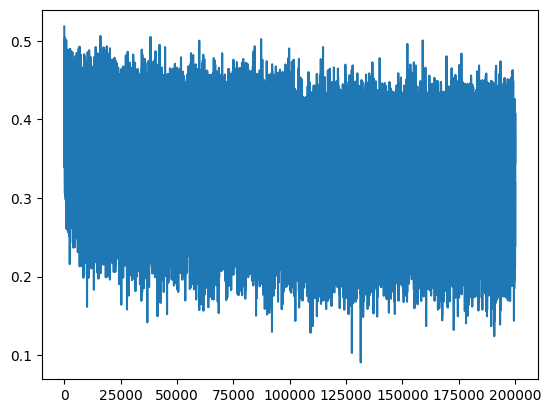

In [56]:
plt.plot(lossi)
plt.show()

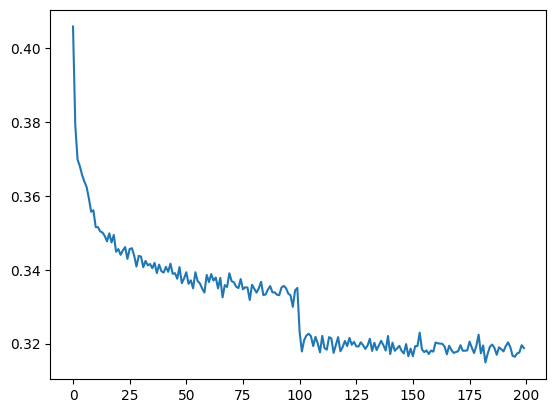

In [59]:
# to make the plot look nicer, we can transform the array of mini-batch losses into some shape
# like (200, 1000), and only plot the means along the rows (mean(1))
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))
# the learning rate decay effect is clearly visible on the graph
plt.show()

In [40]:
# put layers into eval mode
for layer in model.layers:
    layer.training = False

In [41]:
# evaluate the loss
torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0621414184570312
val 2.109346389770508


In [42]:
# sample from the model

for _ in range(20):
    out = []
    context = [0] * block_size 
    while True:
        logits = model(torch.tensor([context]))
        # emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        # x = emb.view(emb.shape[0], -1)
        # for layer in layers:
        #     x = layer(x)
        # logits = x
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples=1).item() # sample from the distribution
        context = context[1:] + [idx] # shift the context window
        out.append(idx)
        if idx == 0:
            break
    print(''.join(itos[i] for i in out))

ivon.
fanili.
thoommasamiel.
emmadery.
andr.
aleigh.
kelynnie.
jazul.
carleen.
jah.
jorra.
alaya.
shonan.
vishylaharia.
juna.
vio.
orven.
meriell.
laiye.
zefina.


---
**Dataset with a context size of 8**:\
Wavenet uses a stack of dilated causal convolutional layers: we stack layers and at each level fuse only two consecutive elements.\
So in the first level, we fuse two characters. Then two bigrams at the first dilation, two fourgrams at the second dilation, and so on. 

In [43]:
block_size = 8
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            idx = stoi[ch]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 8]) torch.Size([182580])
torch.Size([22767, 8]) torch.Size([22767])
torch.Size([22799, 8]) torch.Size([22799])


In [44]:
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

# number of parameters is 22097 -> increased a lot after changing the context length from 3 to 8 

170897


In [45]:
idx = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[idx], Ytr[idx]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0, 13,  1, 18],
        [ 0,  0,  0,  1, 18,  2,  1,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0, 13,  5,  1]])

In [46]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsecutive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsecutive : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


Note on matrix multiplication in PyTorch:\
(torch.randn(4, 80) @ torch.randn(80, 200)).shape is \[4, 200]\
But the input doesn't have to be 2-dimensional. We can pass (torch.randn(4, 5, 6, 80) @ torch.randn(80, 200)).shape\
and PyTorch will only multiply the last column, leaving the others unchanged. So the dimension of the output is \[4, 5, 6, 200]\
**\[4, 80]**: 4 sequences, each with 80 character embeddings. Each character is embedded as a 10-dimensional vector => this actually means 4 sequences x 8 characters x 10 dimensions.\
We don't want all 80 characters to come in in the first layer. Instead, 2 consecutive characters should be fused. 8 characters in each layer become 4 pairs, so each pair has 20 dimensions. Therefore, we change the code line above to (torch.randn(4, 4, 20) @ torch.randn(20, 200)).\
**\[4, 4, 20]**: 4 sequences, 4 characters, 20 dimensions.

(1 2) (3 4) (5 6) (7 8)

In code:\
e = torch.randn(4, 8, 10) # we want this to be (4, 4, 20)
torch.cat(\[e\[:, ::2, :]], \[e\[:, 1::2, :]], dim=2).shape returns \[4, 4, 20]

Basically we take \[:, ::2, :] (every second element along the second dimension) and \[:, 1::2, :] (offset by one and take every second element along the second dimension), and concatenate.\
Instead of doing explicit concatenation, we can just view as a 4x4x20 shape using e.view(4, 4, 20).

Note from my medium article on this lecture from last year:

"One last thing to take out of the video that I will mention is why convolutions are efficient. They “slide” the model over the input sequences, i.e. move the filter (linear layer) across the input sequence, calculating values on a small portion of the input data at each position. You can process all examples in a sequence simultaneously through parallelization on GPUs instead of processing them individually. Convolutions also allow for variable reuse. For example, if a node is both a right child of one node and a left child of another one, convolutions can reuse the node’s value instead of recalculating it each time."